##  This notebook uses transfer Learning from the resnet18 architecture to predict the classes of COVID19, Normal and Pneumonia diagnosed Chest X Ray images. It also looks into how tweaking the layers trained by adding or reducng the number of trainable layers affects the model performance. 

### The dataset can e found at https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia/data

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from pathlib import Path
import PIL
from PIL import Image
from torchvision import transforms
import pandas as pd
import cv2
from tqdm.notebook import tqdm
import torchmetrics
import seaborn as sns

### Analyzing the dataset below shows the counts per class, It can be seen that teh number of examples for COVID19 is much less than that for normal and Pneumonia. A weighted Random Sampler will be used to tackl this issue at a later stage in the notebook.

In [9]:
root_path = Path('Data/train')
labels = []
for folders in root_path.glob('*'):
    for label in folders.glob('*'):
        labels.append(folders.parts[-1])
print(np.unique(np.array(labels), return_counts=True))

(array(['COVID19', 'NORMAL', 'PNEUMONIA'], dtype='<U9'), array([ 460, 1266, 3418], dtype=int64))


###  Looking at the descriptive stats of some of the images the COVID19 subfolder(you can choose to see all) it can be seen that the dimensions vary vastly and even the channel dimensions are composed of 3 and 4 colour channels.

In [3]:
train_path = Path('Data/train/COVID19/')
size_list = []
size_list = [np.asarray(Image.open(i)).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list,columns = ['H', 'W', 'C'] )
df.describe()

,H,W,C
count,460.000000,460.000000,336.000000
mean,1309.558696,1439.773913,3.107143
std,710.897474,805.120157,0.309756
min,224.000000,224.000000,3.000000
25%,744.500000,886.500000,3.000000
50%,1024.000000,1050.500000,3.000000
75%,1971.000000,2000.000000,3.000000
max,4757.000000,5623.000000,4.000000


### The helper function below is used later to convert the images to grayscale and resize the image to 224 x 224 pixels.


In [4]:
def load(path):
    img = Image.open(path)
    img = PIL.ImageOps.grayscale(img) 
    img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
    return img
    
#Check that the helper function works as expected
size_list = [load(i).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list)
df.describe()

,0,1
count,460.0,460.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


### Preprocessing consists of normalizing the images using mean and standard deviation in the training set. Further processsing involves Random Affine, Rotaions, HorizontalFLips, ResizedCrops and Elastic Tranformation for the training dataset and Normalization for the validation dataset.

In [10]:
def mean_std(root_path):
    sums, sum_squared = 0,0
    files = 0
    for path in tqdm(list(root_path.glob('*')), total = len(list(root_path.glob('*')))):
        for p in tqdm(list(path.glob('*'))):
            img = load(p)
            sums+= np.sum(img)/(img.shape[0]*img.shape[1])
            sum_squared+= np.sum(img**2)/(img.shape[0]*img.shape[1])
            files+=1
    print(files)
    mean = sums/files
    std = np.sqrt((sum_squared/files) - (mean**2))
    return mean, std
mean, std = mean_std(Path('Data/train'))
print(mean, std)

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std), transforms.RandomAffine(degrees = (-5,5),
    translate=(0, 0.05),
    scale=(0.9, 1.1)), transforms.RandomRotation(10),transforms.RandomResizedCrop((224,224), #(0.9,1.1),
    scale=(0.35, 1)),
    transforms.RandomHorizontalFlip(p =0.3),
    transforms.ElasticTransform()])
val_transform =  transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/1266 [00:00<?, ?it/s]

  0%|          | 0/3418 [00:00<?, ?it/s]

5144
0.4920391255128484 0.23256543325130302


In [5]:
# mean, std = 0.4920391255128484, 0.23256543325130302

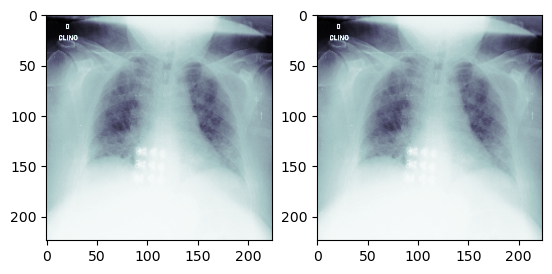

In [16]:
train_path = Path('Data/train/COVID19/')
fig, ax = plt.subplots(1,2)
n = 0
for i in list(train_path.glob('*')):
    ax[n].imshow(im, cmap = 'bone')
    n+=1
    if n==2:
        break

### A custom dataset that takes both the train and test folders and shuffles it, applies transformations. THis provided with better training results that using the train and test folders separately.

In [106]:
class LungDataset(torch.utils.data.Dataset):
    '''
    Custom Dataset to shuffle and transform images in the main Data folder
    
    Arguments:    
    
    rootpath: The main path to folder named Data containing the subfolders
    
    train_tranforms: Tranformations for training data of class torchvision.transforms
    
    val_tranforms: Tranformations for validation data of class torchvision.transforms
    
    num_train: Number of training examples to produce. When making validation set num_train must be equal to num_train
    set for training data.
    
    seed_val: Random seed to produce the shuffle. Must be same for both training and validation dataset creation.
    '''
    def __init__(self, rootpath= None, train_transforms= None, val_transforms= None,num_train= None,seed_val= 42):
        super().__init__()
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.num_train = num_train
        self.filenames = self.extractandshuffle(rootpath, seed_val)

    #Extract all the file paths
    def extractandshuffle(self, path, seed_val):
        files = []
        for paths in list(path.glob('*')):
            # print(paths)
            for classes in list(paths.glob('*')):
                # print(classes)
                for f in list(classes.glob('*')):
                    # print(f)
                    files.append((f, classes))
        #Shuffle the data and split based on train or validation dataset
        np.random.seed(seed_val)
        np.random.shuffle(files)
        if self.train_transforms!=None:
            files = files[:self.num_train]
        else:
            files = files[self.num_train:]
        return files

    #Convert labels to integers
    @staticmethod
    def get_label(path):
        labels =['COVID19', 'NORMAL', 'PNEUMONIA']
        return labels.index(list(path.parts)[-1])
        
    #Convert to greyascale and resize image to 224 x 224    
    def load(self, path, transforms):
        img = Image.open(path)
        img = PIL.ImageOps.grayscale(img) 
        img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
        img = transforms(img)
        return img

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        file_id = self.filenames[index][0]
        label = self.filenames[index][1]
        if self.train_transforms !=None:  
            return self.load(file_id, self.train_transforms), self.get_label(label)
        else:
            return self.load(file_id, self.val_transforms), self.get_label(label)
                

In [19]:
root_path = Path('Data')
train_data = LungDataset(root_path, train_transform, None, 5144, 42)
val_data = LungDataset(root_path, None, val_transform, 5144, 42)

### Calculate class weights to be used in the Random Weighted Sampler

In [ ]:
classes = np.array([i[1] for i in train_data])
weights = np.unique(classes, return_counts=True)[1]
weights = len(classes)/weights
print(np.unique(classes, return_counts=True))
print(weights)
class_weights =[]
for _, label in tqdm(train_data):
    if label == 0:
        class_weights.append(weights[0])
    elif label == 1:
        class_weights.append(weights[1])
    elif label == 2:
        class_weights.append(weights[2])
    else:
        print('Unknown class')

In [20]:
np.save('class_weights_shuffled', class_weights) # Save in case of cars or to be used again in which case it can be loaded.
class_weights =np.load('class_weights_shuffled.npy')

In [21]:
sampler = torch.utils.data.WeightedRandomSampler(weights = class_weights, num_samples=len(train_data))
train_loader = torch.utils.data.DataLoader(dataset = train_data, sampler = sampler, batch_size=10)
val_loader = torch.utils.data.DataLoader(dataset = val_data, shuffle = False, batch_size=10)

In [22]:
len(train_loader), len(val_loader)

(515, 129)

### Check that the train_loader samples as expected

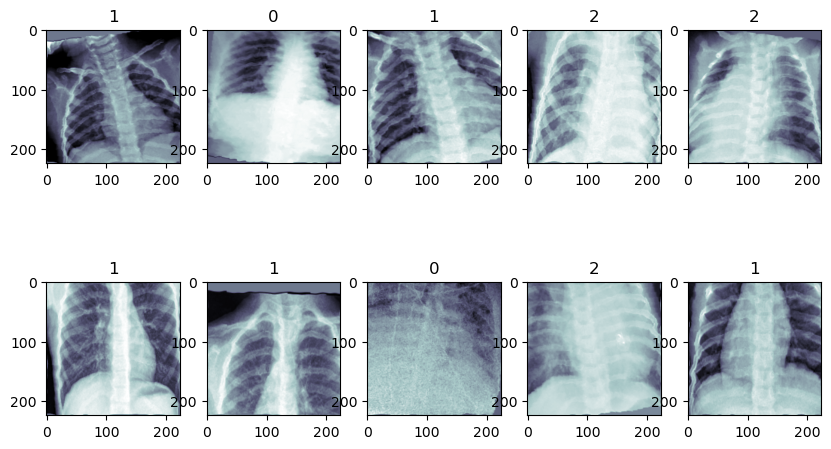

In [23]:
for b, (X,y) in enumerate(train_loader):
    fig, ax = plt.subplots(2,5, figsize =(10,6))
    k=0
    for i in range(2):
        for j in range(5):
            ax[i][j].imshow(np.transpose(X[k].numpy(), (1,2,0)), cmap = 'bone')
            ax[i][j].set_title(y[k].item())
            k+=1

    break

### The resnet18 is used to train the model. A pretrained model is selected. The first conv1 layer which has an input of 3 is changed to an input of 1 since the dataset has grayscale images. The last fully connected layer fc which has outputs 1000 featres is changed to 3 to predict 3 classes. Furthemore helper fuctions to select the layers based on their index to train them is written below and can be used to tweak the number of layers trained.

In [29]:
from torchvision.models import resnet18

In [30]:
model = resnet18(pretrained=True)
model

D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
class ResNet(torch.nn.Module):
    '''
    Class representing the resnet18 pretrained model.

    Arguments:
    in_channels: number of inout channels
    out_features: number of classes to predcit
    layers: list of indices of model layers where requires_grad is set to True to train..
    '''
    def __init__(self,in_channels, out_features, layers =None):
        super().__init__()
        torch.manual_seed(4)
        self.model = resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=out_features, bias=True)
        self.num_parameters = len(list(self.model.named_parameters()))
        if layers:
            for l in range(self.num_parameters):
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = False
            
            for l in layers:           
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = True
                print(f'Setting {name} grad to True') #To print the layers with gradients turned off

    def forward(self, X):
        pred = self.model(X)
        return pred

def optimizer_model_parameters(model, *layers):
    '''
    Return list of paramters for optimizer to optimize according to layers set in ResNet()

    Arguments:
    *layers: arguments of layer indices set to be trained in the ResNet() model
    '''
    param = []
    for i in layers:
        param.append(list(model.parameters())[i])
    return param        

### Model was trained to 50 epochs with the last 5 layers trained with Stochastic Gradient Descent andlearning rate intially set to 0.1 with learning rate decay.

In [40]:
new_model = ResNet(1,3, [0,-5,-4,-3,-2,-1])
new_model;
device = ['cuda:0' if torch.cuda.is_available() == True else 'cpu']
    
epochs = 50
model_parameters = optimizer_model_parameters(new_model, 0,-5,-4,-3,-2,-1)
optimizer = torch.optim.SGD(model_parameters,lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10,gamma = 0.1)
train_losses=[]
val_losses = []
Train_Accuracy= []
Val_Accuracy = []

new_model = new_model.to(device[0])


Setting conv1.weight grad to True
Setting layer4.1.conv2.weight grad to True
Setting layer4.1.bn2.weight grad to True
Setting layer4.1.bn2.bias grad to True
Setting fc.weight grad to True
Setting fc.bias grad to True


In [37]:
#Check to make sure the gradients are set accordingly
for name,p in new_model.named_parameters():
    print(p.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [39]:
for e in tqdm(range(epochs)):
    
    train_batch_corr = 0
    print('**************************Training Results*********************************')
    for b, (X_train, y_train) in tqdm(enumerate(train_loader), total = len(train_loader)):
        
        pred = new_model(X_train.float().to(device[0]))
        loss= criterion(pred.cpu(), y_train)
        train_batch_corr+= torch.sum(torch.argmax(pred.cpu(), dim=1)==y_train).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b % 200 ==0:
            print(f'Epoch,batch: {e,b} Loss:{loss.item()} Accuracy: {train_batch_corr/((b+1)*len(y_train))}')
          
    lr_scheduler.step()
    train_losses.append(loss.item())
    Train_Accuracy.append(train_batch_corr/(len(train_data)))
    print(f'Epoch: {e}  Train Accuracy: {train_batch_corr/(len(train_data))}')
    
    
    print('**************************Validation Results*********************************')
    with torch.no_grad():        
        val_batch_corr = 0
        
        for b_t, (X_test, y_test) in tqdm(enumerate(val_loader), total = len(val_loader)):
            
            val_pred = new_model(X_test.float().to(device[0]))
            vloss= criterion(val_pred.cpu(), y_test)
            val_batch_corr+= torch.sum(torch.argmax(val_pred.cpu(), dim=1)==y_test).item()
            if b_t % 50 ==0:
                
                print(f'Epoch,batch: {e,b_t} Loss:{vloss.item()} Accuracy: {val_batch_corr/((b_t+1)*len(y_test))}')
        val_losses.append(vloss.item())           
        Val_Accuracy.append(val_batch_corr/(len(val_data)))
        print(f'Epoch: {e}  Val Accuracy: {val_batch_corr/(len(val_data))}')

  0%|          | 0/50 [00:00<?, ?it/s]

**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

D:\anaconda3\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,batch: (0, 0) Loss:0.9951651692390442 Accuracy: 0.5
Epoch,batch: (0, 200) Loss:0.42263031005859375 Accuracy: 0.6950248756218905
Epoch,batch: (0, 400) Loss:0.3502703309059143 Accuracy: 0.7548628428927681
Epoch: 0  Train Accuracy: 0.7731337480559876
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (0, 0) Loss:1.4735291004180908 Accuracy: 0.5
Epoch,batch: (0, 50) Loss:1.1386302709579468 Accuracy: 0.6196078431372549
Epoch,batch: (0, 100) Loss:1.2048218250274658 Accuracy: 0.595049504950495
Epoch: 0  Val Accuracy: 0.59472049689441
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (1, 0) Loss:0.6606588363647461 Accuracy: 0.6
Epoch,batch: (1, 200) Loss:0.5068906545639038 Accuracy: 0.8512437810945274
Epoch,batch: (1, 400) Loss:0.40716180205345154 Accuracy: 0.8511221945137157
Epoch: 1  Train Accuracy: 0.85400466562986
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (1, 0) Loss:0.7517830729484558 Accuracy: 0.6
Epoch,batch: (1, 50) Loss:0.5814089775085449 Accuracy: 0.7431372549019608
Epoch,batch: (1, 100) Loss:0.5379974246025085 Accuracy: 0.7247524752475247
Epoch: 1  Val Accuracy: 0.7236024844720497
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (2, 0) Loss:0.35201823711395264 Accuracy: 0.8
Epoch,batch: (2, 200) Loss:0.5033345818519592 Accuracy: 0.8676616915422886
Epoch,batch: (2, 400) Loss:0.11049028486013412 Accuracy: 0.8675810473815462
Epoch: 2  Train Accuracy: 0.8662519440124417
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (2, 0) Loss:0.5383936762809753 Accuracy: 0.8
Epoch,batch: (2, 50) Loss:0.632200300693512 Accuracy: 0.8058823529411765
Epoch,batch: (2, 100) Loss:0.43743896484375 Accuracy: 0.7960396039603961
Epoch: 2  Val Accuracy: 0.7989130434782609
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (3, 0) Loss:0.18902543187141418 Accuracy: 0.9
Epoch,batch: (3, 200) Loss:0.2994212508201599 Accuracy: 0.8865671641791045
Epoch,batch: (3, 400) Loss:0.1259928196668625 Accuracy: 0.8810473815461347
Epoch: 3  Train Accuracy: 0.8818040435458787
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (3, 0) Loss:0.44970956444740295 Accuracy: 0.8
Epoch,batch: (3, 50) Loss:0.3716811537742615 Accuracy: 0.8549019607843137
Epoch,batch: (3, 100) Loss:0.401073694229126 Accuracy: 0.8415841584158416
Epoch: 3  Val Accuracy: 0.843167701863354
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (4, 0) Loss:0.1417485773563385 Accuracy: 1.0
Epoch,batch: (4, 200) Loss:0.20898935198783875 Accuracy: 0.9014925373134328
Epoch,batch: (4, 400) Loss:0.34044942259788513 Accuracy: 0.897506234413965
Epoch: 4  Train Accuracy: 0.8993001555209953
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (4, 0) Loss:0.5539140701293945 Accuracy: 0.8
Epoch,batch: (4, 50) Loss:0.5255452990531921 Accuracy: 0.8450980392156863
Epoch,batch: (4, 100) Loss:0.46242719888687134 Accuracy: 0.8247524752475247
Epoch: 4  Val Accuracy: 0.828416149068323
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (5, 0) Loss:0.14293618500232697 Accuracy: 0.9
Epoch,batch: (5, 200) Loss:0.1686488538980484 Accuracy: 0.8930348258706468
Epoch,batch: (5, 400) Loss:0.21890203654766083 Accuracy: 0.8967581047381546
Epoch: 5  Train Accuracy: 0.8998833592534993
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (5, 0) Loss:0.9852369427680969 Accuracy: 0.6
Epoch,batch: (5, 50) Loss:1.0615155696868896 Accuracy: 0.7058823529411765
Epoch,batch: (5, 100) Loss:1.0479590892791748 Accuracy: 0.6772277227722773
Epoch: 5  Val Accuracy: 0.6762422360248447
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (6, 0) Loss:0.20668521523475647 Accuracy: 0.9
Epoch,batch: (6, 200) Loss:0.07577770948410034 Accuracy: 0.9074626865671642
Epoch,batch: (6, 400) Loss:0.19121603667736053 Accuracy: 0.9032418952618454
Epoch: 6  Train Accuracy: 0.9016329704510109
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (6, 0) Loss:0.35950008034706116 Accuracy: 0.8
Epoch,batch: (6, 50) Loss:0.4633944630622864 Accuracy: 0.8647058823529412
Epoch,batch: (6, 100) Loss:0.3686183989048004 Accuracy: 0.8534653465346534
Epoch: 6  Val Accuracy: 0.8586956521739131
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (7, 0) Loss:0.1309678852558136 Accuracy: 1.0
Epoch,batch: (7, 200) Loss:0.1697102189064026 Accuracy: 0.8975124378109453
Epoch,batch: (7, 400) Loss:0.28475281596183777 Accuracy: 0.8992518703241895
Epoch: 7  Train Accuracy: 0.9008553654743391
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (7, 0) Loss:0.602030873298645 Accuracy: 0.8
Epoch,batch: (7, 50) Loss:0.4583420753479004 Accuracy: 0.8725490196078431
Epoch,batch: (7, 100) Loss:0.5160350799560547 Accuracy: 0.8524752475247525
Epoch: 7  Val Accuracy: 0.8509316770186336
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (8, 0) Loss:0.14034420251846313 Accuracy: 1.0
Epoch,batch: (8, 200) Loss:0.1251755952835083 Accuracy: 0.9139303482587064
Epoch,batch: (8, 400) Loss:0.1950208842754364 Accuracy: 0.9109725685785536
Epoch: 8  Train Accuracy: 0.9088258164852255
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (8, 0) Loss:0.48357582092285156 Accuracy: 0.8
Epoch,batch: (8, 50) Loss:0.44684019684791565 Accuracy: 0.8509803921568627
Epoch,batch: (8, 100) Loss:0.4852045178413391 Accuracy: 0.8356435643564356
Epoch: 8  Val Accuracy: 0.8354037267080745
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (9, 0) Loss:0.03005576692521572 Accuracy: 1.0
Epoch,batch: (9, 200) Loss:0.33942335844039917 Accuracy: 0.9099502487562189
Epoch,batch: (9, 400) Loss:0.24529676139354706 Accuracy: 0.9119700748129675
Epoch: 9  Train Accuracy: 0.911353032659409
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (9, 0) Loss:0.3738149106502533 Accuracy: 0.8
Epoch,batch: (9, 50) Loss:0.21332350373268127 Accuracy: 0.8901960784313725
Epoch,batch: (9, 100) Loss:0.34902745485305786 Accuracy: 0.8782178217821782
Epoch: 9  Val Accuracy: 0.8827639751552795
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (10, 0) Loss:0.0750742107629776 Accuracy: 1.0
Epoch,batch: (10, 200) Loss:0.16615359485149384 Accuracy: 0.9218905472636816
Epoch,batch: (10, 400) Loss:0.033203572034835815 Accuracy: 0.9256857855361597
Epoch: 10  Train Accuracy: 0.9272939346811819
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (10, 0) Loss:0.758156955242157 Accuracy: 0.8
Epoch,batch: (10, 50) Loss:0.49184346199035645 Accuracy: 0.8274509803921568
Epoch,batch: (10, 100) Loss:0.705962061882019 Accuracy: 0.7980198019801981
Epoch: 10  Val Accuracy: 0.8012422360248447
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (11, 0) Loss:0.06974460929632187 Accuracy: 1.0
Epoch,batch: (11, 200) Loss:0.43244972825050354 Accuracy: 0.9139303482587064
Epoch,batch: (11, 400) Loss:0.1809423863887787 Accuracy: 0.9192019950124688
Epoch: 11  Train Accuracy: 0.9224339035769828
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (11, 0) Loss:0.7217098474502563 Accuracy: 0.8
Epoch,batch: (11, 50) Loss:0.48363786935806274 Accuracy: 0.8352941176470589
Epoch,batch: (11, 100) Loss:0.6675421595573425 Accuracy: 0.802970297029703
Epoch: 11  Val Accuracy: 0.8051242236024845
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (12, 0) Loss:0.04249893128871918 Accuracy: 1.0
Epoch,batch: (12, 200) Loss:0.06023962050676346 Accuracy: 0.9238805970149254
Epoch,batch: (12, 400) Loss:0.5006674528121948 Accuracy: 0.9276807980049875
Epoch: 12  Train Accuracy: 0.9280715396578538
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (12, 0) Loss:0.6765705943107605 Accuracy: 0.8
Epoch,batch: (12, 50) Loss:0.48908257484436035 Accuracy: 0.8372549019607843
Epoch,batch: (12, 100) Loss:0.6801512241363525 Accuracy: 0.806930693069307
Epoch: 12  Val Accuracy: 0.8082298136645962
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (13, 0) Loss:0.2820295989513397 Accuracy: 0.9
Epoch,batch: (13, 200) Loss:0.05197152495384216 Accuracy: 0.9288557213930348
Epoch,batch: (13, 400) Loss:0.2980627715587616 Accuracy: 0.9331670822942644
Epoch: 13  Train Accuracy: 0.9339035769828927
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (13, 0) Loss:0.6432892084121704 Accuracy: 0.8
Epoch,batch: (13, 50) Loss:0.4605214595794678 Accuracy: 0.8470588235294118
Epoch,batch: (13, 100) Loss:0.6272570490837097 Accuracy: 0.8217821782178217
Epoch: 13  Val Accuracy: 0.8245341614906833
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (14, 0) Loss:0.07474619150161743 Accuracy: 1.0
Epoch,batch: (14, 200) Loss:0.053842853754758835 Accuracy: 0.9194029850746268
Epoch,batch: (14, 400) Loss:0.25394219160079956 Accuracy: 0.9211970074812967
Epoch: 14  Train Accuracy: 0.9193234836702955
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (14, 0) Loss:0.7051753997802734 Accuracy: 0.8
Epoch,batch: (14, 50) Loss:0.49117112159729004 Accuracy: 0.8588235294117647
Epoch,batch: (14, 100) Loss:0.6607992649078369 Accuracy: 0.8346534653465346
Epoch: 14  Val Accuracy: 0.8354037267080745
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (15, 0) Loss:0.12983401119709015 Accuracy: 1.0
Epoch,batch: (15, 200) Loss:0.03218582645058632 Accuracy: 0.917910447761194
Epoch,batch: (15, 400) Loss:0.1590074747800827 Accuracy: 0.9291770573566085
Epoch: 15  Train Accuracy: 0.9292379471228616
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (15, 0) Loss:0.6612289547920227 Accuracy: 0.8
Epoch,batch: (15, 50) Loss:0.42867812514305115 Accuracy: 0.8725490196078431
Epoch,batch: (15, 100) Loss:0.587992787361145 Accuracy: 0.8435643564356435
Epoch: 15  Val Accuracy: 0.8470496894409938
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (16, 0) Loss:0.047006044536828995 Accuracy: 1.0
Epoch,batch: (16, 200) Loss:0.03450139984488487 Accuracy: 0.9288557213930348
Epoch,batch: (16, 400) Loss:0.09312465041875839 Accuracy: 0.929925187032419
Epoch: 16  Train Accuracy: 0.9288491446345256
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (16, 0) Loss:0.7228133082389832 Accuracy: 0.8
Epoch,batch: (16, 50) Loss:0.4841728210449219 Accuracy: 0.8470588235294118
Epoch,batch: (16, 100) Loss:0.7045404314994812 Accuracy: 0.8227722772277227
Epoch: 16  Val Accuracy: 0.8237577639751553
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (17, 0) Loss:0.10587625205516815 Accuracy: 1.0
Epoch,batch: (17, 200) Loss:0.20463988184928894 Accuracy: 0.927860696517413
Epoch,batch: (17, 400) Loss:0.14845997095108032 Accuracy: 0.9286783042394015
Epoch: 17  Train Accuracy: 0.9292379471228616
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (17, 0) Loss:0.7530910968780518 Accuracy: 0.8
Epoch,batch: (17, 50) Loss:0.47879377007484436 Accuracy: 0.8470588235294118
Epoch,batch: (17, 100) Loss:0.7640700340270996 Accuracy: 0.8277227722772277
Epoch: 17  Val Accuracy: 0.8299689440993789
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (18, 0) Loss:0.06860867887735367 Accuracy: 1.0
Epoch,batch: (18, 200) Loss:0.0889623612165451 Accuracy: 0.9378109452736318
Epoch,batch: (18, 400) Loss:0.015823446214199066 Accuracy: 0.9329177057356608
Epoch: 18  Train Accuracy: 0.9290435458786936
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (18, 0) Loss:0.6177369952201843 Accuracy: 0.8
Epoch,batch: (18, 50) Loss:0.43172892928123474 Accuracy: 0.8725490196078431
Epoch,batch: (18, 100) Loss:0.5603936910629272 Accuracy: 0.8465346534653465
Epoch: 18  Val Accuracy: 0.8517080745341615
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (19, 0) Loss:0.17115284502506256 Accuracy: 0.9
Epoch,batch: (19, 200) Loss:0.1926097273826599 Accuracy: 0.9273631840796019
Epoch,batch: (19, 400) Loss:0.42530712485313416 Accuracy: 0.9326683291770573
Epoch: 19  Train Accuracy: 0.9319595645412131
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (19, 0) Loss:0.6951903700828552 Accuracy: 0.8
Epoch,batch: (19, 50) Loss:0.495629221200943 Accuracy: 0.8470588235294118
Epoch,batch: (19, 100) Loss:0.6805686950683594 Accuracy: 0.8227722772277227
Epoch: 19  Val Accuracy: 0.8260869565217391
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (20, 0) Loss:0.06572972983121872 Accuracy: 1.0
Epoch,batch: (20, 200) Loss:0.1307412087917328 Accuracy: 0.9323383084577115
Epoch,batch: (20, 400) Loss:0.5174262523651123 Accuracy: 0.9341645885286783
Epoch: 20  Train Accuracy: 0.9305987558320373
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (20, 0) Loss:0.6382895708084106 Accuracy: 0.8
Epoch,batch: (20, 50) Loss:0.43046683073043823 Accuracy: 0.8666666666666667
Epoch,batch: (20, 100) Loss:0.61455899477005 Accuracy: 0.8435643564356435
Epoch: 20  Val Accuracy: 0.8486024844720497
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (21, 0) Loss:0.16522328555583954 Accuracy: 0.9
Epoch,batch: (21, 200) Loss:0.1558012068271637 Accuracy: 0.9447761194029851
Epoch,batch: (21, 400) Loss:0.13812591135501862 Accuracy: 0.9403990024937656
Epoch: 21  Train Accuracy: 0.9385692068429238
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (21, 0) Loss:0.6592875719070435 Accuracy: 0.8
Epoch,batch: (21, 50) Loss:0.4577779173851013 Accuracy: 0.8568627450980392
Epoch,batch: (21, 100) Loss:0.6364065408706665 Accuracy: 0.8326732673267326
Epoch: 21  Val Accuracy: 0.8361801242236024
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (22, 0) Loss:0.39598676562309265 Accuracy: 0.7
Epoch,batch: (22, 200) Loss:0.033569011837244034 Accuracy: 0.9353233830845771
Epoch,batch: (22, 400) Loss:0.3682144582271576 Accuracy: 0.9396508728179551
Epoch: 22  Train Accuracy: 0.9397356143079316
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (22, 0) Loss:0.6652721762657166 Accuracy: 0.8
Epoch,batch: (22, 50) Loss:0.46534475684165955 Accuracy: 0.8549019607843137
Epoch,batch: (22, 100) Loss:0.6466027498245239 Accuracy: 0.8287128712871287
Epoch: 22  Val Accuracy: 0.8322981366459627
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (23, 0) Loss:0.01535760797560215 Accuracy: 1.0
Epoch,batch: (23, 200) Loss:0.038888491690158844 Accuracy: 0.9308457711442786
Epoch,batch: (23, 400) Loss:0.18170425295829773 Accuracy: 0.9329177057356608
Epoch: 23  Train Accuracy: 0.9309875583203733
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (23, 0) Loss:0.6420921683311462 Accuracy: 0.8
Epoch,batch: (23, 50) Loss:0.4399951100349426 Accuracy: 0.8549019607843137
Epoch,batch: (23, 100) Loss:0.6193529367446899 Accuracy: 0.8316831683168316
Epoch: 23  Val Accuracy: 0.8369565217391305
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (24, 0) Loss:0.27460673451423645 Accuracy: 0.9
Epoch,batch: (24, 200) Loss:0.038821157068014145 Accuracy: 0.9323383084577115
Epoch,batch: (24, 400) Loss:0.04335533082485199 Accuracy: 0.9291770573566085
Epoch: 24  Train Accuracy: 0.9296267496111975
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (24, 0) Loss:0.6362422108650208 Accuracy: 0.8
Epoch,batch: (24, 50) Loss:0.4271724224090576 Accuracy: 0.8647058823529412
Epoch,batch: (24, 100) Loss:0.6088806390762329 Accuracy: 0.8415841584158416
Epoch: 24  Val Accuracy: 0.8454968944099379
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (25, 0) Loss:0.050376854836940765 Accuracy: 1.0
Epoch,batch: (25, 200) Loss:0.2738305628299713 Accuracy: 0.935820895522388
Epoch,batch: (25, 400) Loss:0.09935487806797028 Accuracy: 0.9361596009975063
Epoch: 25  Train Accuracy: 0.9366251944012441
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (25, 0) Loss:0.6646410226821899 Accuracy: 0.8
Epoch,batch: (25, 50) Loss:0.45778924226760864 Accuracy: 0.8568627450980392
Epoch,batch: (25, 100) Loss:0.641620934009552 Accuracy: 0.8326732673267326
Epoch: 25  Val Accuracy: 0.8354037267080745
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (26, 0) Loss:0.27608782052993774 Accuracy: 0.9
Epoch,batch: (26, 200) Loss:0.15096092224121094 Accuracy: 0.9398009950248756
Epoch,batch: (26, 400) Loss:0.2144201248884201 Accuracy: 0.9356608478802992
Epoch: 26  Train Accuracy: 0.9331259720062208
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (26, 0) Loss:0.6498961448669434 Accuracy: 0.8
Epoch,batch: (26, 50) Loss:0.4452973008155823 Accuracy: 0.8588235294117647
Epoch,batch: (26, 100) Loss:0.6209670901298523 Accuracy: 0.8336633663366336
Epoch: 26  Val Accuracy: 0.8385093167701864
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (27, 0) Loss:0.2925119996070862 Accuracy: 0.9
Epoch,batch: (27, 200) Loss:0.03759041428565979 Accuracy: 0.9383084577114428
Epoch,batch: (27, 400) Loss:0.2478700876235962 Accuracy: 0.9374064837905237
Epoch: 27  Train Accuracy: 0.937791601866252
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (27, 0) Loss:0.6632094979286194 Accuracy: 0.8
Epoch,batch: (27, 50) Loss:0.4511493146419525 Accuracy: 0.8568627450980392
Epoch,batch: (27, 100) Loss:0.6372286677360535 Accuracy: 0.8326732673267326
Epoch: 27  Val Accuracy: 0.8361801242236024
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (28, 0) Loss:0.1302291452884674 Accuracy: 1.0
Epoch,batch: (28, 200) Loss:0.12365881353616714 Accuracy: 0.9338308457711443
Epoch,batch: (28, 400) Loss:0.021672068163752556 Accuracy: 0.9326683291770573
Epoch: 28  Train Accuracy: 0.932153965785381
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (28, 0) Loss:0.6506536602973938 Accuracy: 0.8
Epoch,batch: (28, 50) Loss:0.44006624817848206 Accuracy: 0.8607843137254902
Epoch,batch: (28, 100) Loss:0.6204498410224915 Accuracy: 0.8366336633663366
Epoch: 28  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (29, 0) Loss:0.31772083044052124 Accuracy: 0.9
Epoch,batch: (29, 200) Loss:0.19874626398086548 Accuracy: 0.936318407960199
Epoch,batch: (29, 400) Loss:0.27951478958129883 Accuracy: 0.9346633416458853
Epoch: 29  Train Accuracy: 0.9379860031104199
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (29, 0) Loss:0.6553834080696106 Accuracy: 0.8
Epoch,batch: (29, 50) Loss:0.43803033232688904 Accuracy: 0.8607843137254902
Epoch,batch: (29, 100) Loss:0.6204317212104797 Accuracy: 0.8366336633663366
Epoch: 29  Val Accuracy: 0.8416149068322981
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (30, 0) Loss:0.2632121741771698 Accuracy: 0.9
Epoch,batch: (30, 200) Loss:0.2547380030155182 Accuracy: 0.93681592039801
Epoch,batch: (30, 400) Loss:0.09704341739416122 Accuracy: 0.9379052369077306
Epoch: 30  Train Accuracy: 0.9385692068429238
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (30, 0) Loss:0.6469755172729492 Accuracy: 0.8
Epoch,batch: (30, 50) Loss:0.4319680333137512 Accuracy: 0.8647058823529412
Epoch,batch: (30, 100) Loss:0.6105774641036987 Accuracy: 0.8386138613861386
Epoch: 30  Val Accuracy: 0.842391304347826
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (31, 0) Loss:0.25562453269958496 Accuracy: 0.9
Epoch,batch: (31, 200) Loss:0.2125055491924286 Accuracy: 0.9263681592039801
Epoch,batch: (31, 400) Loss:0.04174427688121796 Accuracy: 0.9324189526184539
Epoch: 31  Train Accuracy: 0.932348367029549
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (31, 0) Loss:0.6508181691169739 Accuracy: 0.8
Epoch,batch: (31, 50) Loss:0.43548670411109924 Accuracy: 0.8627450980392157
Epoch,batch: (31, 100) Loss:0.6150062680244446 Accuracy: 0.8376237623762376
Epoch: 31  Val Accuracy: 0.8416149068322981
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (32, 0) Loss:0.2602246403694153 Accuracy: 0.8
Epoch,batch: (32, 200) Loss:0.22924792766571045 Accuracy: 0.927860696517413
Epoch,batch: (32, 400) Loss:0.17813676595687866 Accuracy: 0.9319201995012469
Epoch: 32  Train Accuracy: 0.9348755832037325
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (32, 0) Loss:0.6528077721595764 Accuracy: 0.8
Epoch,batch: (32, 50) Loss:0.4384990632534027 Accuracy: 0.8607843137254902
Epoch,batch: (32, 100) Loss:0.617087185382843 Accuracy: 0.8366336633663366
Epoch: 32  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (33, 0) Loss:0.07538727670907974 Accuracy: 1.0
Epoch,batch: (33, 200) Loss:0.10072404146194458 Accuracy: 0.9273631840796019
Epoch,batch: (33, 400) Loss:0.504201352596283 Accuracy: 0.9326683291770573
Epoch: 33  Train Accuracy: 0.9344867807153966
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (33, 0) Loss:0.6526070833206177 Accuracy: 0.8
Epoch,batch: (33, 50) Loss:0.4389778971672058 Accuracy: 0.8607843137254902
Epoch,batch: (33, 100) Loss:0.616753876209259 Accuracy: 0.8366336633663366
Epoch: 33  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (34, 0) Loss:0.06902977079153061 Accuracy: 1.0
Epoch,batch: (34, 200) Loss:0.04223208874464035 Accuracy: 0.945273631840796
Epoch,batch: (34, 400) Loss:0.2780260145664215 Accuracy: 0.9379052369077306
Epoch: 34  Train Accuracy: 0.9370139968895801
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (34, 0) Loss:0.6551695466041565 Accuracy: 0.8
Epoch,batch: (34, 50) Loss:0.4414489269256592 Accuracy: 0.8607843137254902
Epoch,batch: (34, 100) Loss:0.6205006837844849 Accuracy: 0.8366336633663366
Epoch: 34  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (35, 0) Loss:0.25722864270210266 Accuracy: 0.9
Epoch,batch: (35, 200) Loss:0.02501397393643856 Accuracy: 0.9338308457711443
Epoch,batch: (35, 400) Loss:0.171962708234787 Accuracy: 0.9371571072319203
Epoch: 35  Train Accuracy: 0.9356531881804043
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (35, 0) Loss:0.6562625169754028 Accuracy: 0.8
Epoch,batch: (35, 50) Loss:0.44422730803489685 Accuracy: 0.8607843137254902
Epoch,batch: (35, 100) Loss:0.6214136481285095 Accuracy: 0.8366336633663366
Epoch: 35  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (36, 0) Loss:0.17447806894779205 Accuracy: 0.9
Epoch,batch: (36, 200) Loss:0.08255107700824738 Accuracy: 0.9422885572139303
Epoch,batch: (36, 400) Loss:0.02444910630583763 Accuracy: 0.9413965087281796
Epoch: 36  Train Accuracy: 0.9395412130637636
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (36, 0) Loss:0.6503864526748657 Accuracy: 0.8
Epoch,batch: (36, 50) Loss:0.4397331178188324 Accuracy: 0.8607843137254902
Epoch,batch: (36, 100) Loss:0.6142078042030334 Accuracy: 0.8366336633663366
Epoch: 36  Val Accuracy: 0.8408385093167702
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (37, 0) Loss:0.47389188408851624 Accuracy: 0.8
Epoch,batch: (37, 200) Loss:0.0710005909204483 Accuracy: 0.936318407960199
Epoch,batch: (37, 400) Loss:0.008977736346423626 Accuracy: 0.9306733167082294
Epoch: 37  Train Accuracy: 0.9305987558320373
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (37, 0) Loss:0.6581053137779236 Accuracy: 0.8
Epoch,batch: (37, 50) Loss:0.4453873038291931 Accuracy: 0.8588235294117647
Epoch,batch: (37, 100) Loss:0.623947262763977 Accuracy: 0.8356435643564356
Epoch: 37  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (38, 0) Loss:0.9723571538925171 Accuracy: 0.8
Epoch,batch: (38, 200) Loss:0.026158709079027176 Accuracy: 0.9467661691542288
Epoch,batch: (38, 400) Loss:0.11371825635433197 Accuracy: 0.9438902743142145
Epoch: 38  Train Accuracy: 0.9401244167962675
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (38, 0) Loss:0.6631516218185425 Accuracy: 0.8
Epoch,batch: (38, 50) Loss:0.4510892927646637 Accuracy: 0.8607843137254902
Epoch,batch: (38, 100) Loss:0.6304640769958496 Accuracy: 0.8366336633663366
Epoch: 38  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (39, 0) Loss:0.036975447088479996 Accuracy: 1.0
Epoch,batch: (39, 200) Loss:0.10494957119226456 Accuracy: 0.93681592039801
Epoch,batch: (39, 400) Loss:0.0057056057266891 Accuracy: 0.9324189526184539
Epoch: 39  Train Accuracy: 0.9356531881804043
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (39, 0) Loss:0.6570160388946533 Accuracy: 0.8
Epoch,batch: (39, 50) Loss:0.44580402970314026 Accuracy: 0.8588235294117647
Epoch,batch: (39, 100) Loss:0.6236929893493652 Accuracy: 0.8356435643564356
Epoch: 39  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (40, 0) Loss:0.12055239826440811 Accuracy: 0.9
Epoch,batch: (40, 200) Loss:0.06187465041875839 Accuracy: 0.9373134328358209
Epoch,batch: (40, 400) Loss:0.4353553354740143 Accuracy: 0.9391521197007481
Epoch: 40  Train Accuracy: 0.9410964230171073
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (40, 0) Loss:0.6579599380493164 Accuracy: 0.8
Epoch,batch: (40, 50) Loss:0.44673556089401245 Accuracy: 0.8588235294117647
Epoch,batch: (40, 100) Loss:0.6247645616531372 Accuracy: 0.8356435643564356
Epoch: 40  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (41, 0) Loss:0.0733787938952446 Accuracy: 1.0
Epoch,batch: (41, 200) Loss:0.09540294110774994 Accuracy: 0.9323383084577115
Epoch,batch: (41, 400) Loss:0.05998609587550163 Accuracy: 0.9316708229426434
Epoch: 41  Train Accuracy: 0.9344867807153966
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (41, 0) Loss:0.6572211980819702 Accuracy: 0.8
Epoch,batch: (41, 50) Loss:0.44627851247787476 Accuracy: 0.8588235294117647
Epoch,batch: (41, 100) Loss:0.6238175630569458 Accuracy: 0.8356435643564356
Epoch: 41  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (42, 0) Loss:0.04581766575574875 Accuracy: 1.0
Epoch,batch: (42, 200) Loss:0.34907227754592896 Accuracy: 0.9407960199004975
Epoch,batch: (42, 400) Loss:0.10852843523025513 Accuracy: 0.9369077306733167
Epoch: 42  Train Accuracy: 0.9368195956454122
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (42, 0) Loss:0.6567097902297974 Accuracy: 0.8
Epoch,batch: (42, 50) Loss:0.44596490263938904 Accuracy: 0.8588235294117647
Epoch,batch: (42, 100) Loss:0.6231602430343628 Accuracy: 0.8356435643564356
Epoch: 42  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (43, 0) Loss:0.3046463131904602 Accuracy: 0.8
Epoch,batch: (43, 200) Loss:0.1506844460964203 Accuracy: 0.9318407960199006
Epoch,batch: (43, 400) Loss:0.16297487914562225 Accuracy: 0.9334164588528678
Epoch: 43  Train Accuracy: 0.932542768273717
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (43, 0) Loss:0.6566392183303833 Accuracy: 0.8
Epoch,batch: (43, 50) Loss:0.44608110189437866 Accuracy: 0.8588235294117647
Epoch,batch: (43, 100) Loss:0.623043954372406 Accuracy: 0.8356435643564356
Epoch: 43  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (44, 0) Loss:0.3159884810447693 Accuracy: 0.9
Epoch,batch: (44, 200) Loss:0.13254466652870178 Accuracy: 0.926865671641791
Epoch,batch: (44, 400) Loss:0.044610124081373215 Accuracy: 0.9321695760598504
Epoch: 44  Train Accuracy: 0.9339035769828927
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (44, 0) Loss:0.6565335392951965 Accuracy: 0.8
Epoch,batch: (44, 50) Loss:0.44584670662879944 Accuracy: 0.8588235294117647
Epoch,batch: (44, 100) Loss:0.6229286789894104 Accuracy: 0.8356435643564356
Epoch: 44  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (45, 0) Loss:0.22684824466705322 Accuracy: 0.9
Epoch,batch: (45, 200) Loss:0.13810887932777405 Accuracy: 0.9348258706467661
Epoch,batch: (45, 400) Loss:0.3250780701637268 Accuracy: 0.9408977556109726
Epoch: 45  Train Accuracy: 0.9395412130637636
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (45, 0) Loss:0.6564673781394958 Accuracy: 0.8
Epoch,batch: (45, 50) Loss:0.44578203558921814 Accuracy: 0.8588235294117647
Epoch,batch: (45, 100) Loss:0.622871994972229 Accuracy: 0.8356435643564356
Epoch: 45  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (46, 0) Loss:0.18857643008232117 Accuracy: 0.9
Epoch,batch: (46, 200) Loss:0.13428819179534912 Accuracy: 0.9333333333333333
Epoch,batch: (46, 400) Loss:0.04313160851597786 Accuracy: 0.9316708229426434
Epoch: 46  Train Accuracy: 0.9348755832037325
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (46, 0) Loss:0.656004786491394 Accuracy: 0.8
Epoch,batch: (46, 50) Loss:0.44534191489219666 Accuracy: 0.8588235294117647
Epoch,batch: (46, 100) Loss:0.6222928762435913 Accuracy: 0.8356435643564356
Epoch: 46  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (47, 0) Loss:0.0413203164935112 Accuracy: 1.0
Epoch,batch: (47, 200) Loss:0.0948190838098526 Accuracy: 0.9378109452736318
Epoch,batch: (47, 400) Loss:0.031338345259428024 Accuracy: 0.9319201995012469
Epoch: 47  Train Accuracy: 0.9354587869362364
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (47, 0) Loss:0.6561237573623657 Accuracy: 0.8
Epoch,batch: (47, 50) Loss:0.4455678462982178 Accuracy: 0.8588235294117647
Epoch,batch: (47, 100) Loss:0.6224780082702637 Accuracy: 0.8356435643564356
Epoch: 47  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (48, 0) Loss:0.23320230841636658 Accuracy: 0.9
Epoch,batch: (48, 200) Loss:0.45321208238601685 Accuracy: 0.9253731343283582
Epoch,batch: (48, 400) Loss:0.32192814350128174 Accuracy: 0.9324189526184539
Epoch: 48  Train Accuracy: 0.9348755832037325
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (48, 0) Loss:0.6554276347160339 Accuracy: 0.8
Epoch,batch: (48, 50) Loss:0.4451464116573334 Accuracy: 0.8588235294117647
Epoch,batch: (48, 100) Loss:0.6216586828231812 Accuracy: 0.8356435643564356
Epoch: 48  Val Accuracy: 0.8400621118012422
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (49, 0) Loss:0.03334232047200203 Accuracy: 1.0
Epoch,batch: (49, 200) Loss:0.37103769183158875 Accuracy: 0.9437810945273631
Epoch,batch: (49, 400) Loss:0.030467133969068527 Accuracy: 0.9379052369077306
Epoch: 49  Train Accuracy: 0.9368195956454122
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (49, 0) Loss:0.6555262207984924 Accuracy: 0.8
Epoch,batch: (49, 50) Loss:0.44514480233192444 Accuracy: 0.8588235294117647
Epoch,batch: (49, 100) Loss:0.621808648109436 Accuracy: 0.8356435643564356
Epoch: 49  Val Accuracy: 0.8400621118012422


### Save model dictionary and metrics

In [41]:
torch.save(new_model.state_dict(), 'Shuffled_model_5_layers_lr0,1gamma0,1_step10(2)')
metrics_dict = {"Train_Accuracy": Train_Accuracy,"Val_Accuracy" : Val_Accuracy, "Train_loss": train_losses, "Val_Loss":val_losses}
with open('Shuffled_model_5_layers_lr0,1gamma0,1_step10_Metrics(2).txt', 'w') as f:
    f.write(str(metrics_dict))

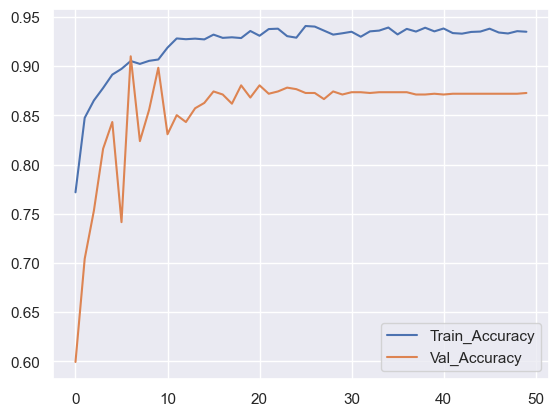

In [83]:
with open('Shuffled_model_5_layers_lr0,1gamma0,1_step10_Metrics.txt','r') as f:
    d=f.read()
#Copy and paste the read file in d
d={'Train_Accuracy': [0.7717729393468118, 0.8473950233281493, 0.8650855365474339, 0.8777216174183515, 0.8913297045101088, 0.8971617418351477, 0.9051321928460342, 0.9022161741835147, 0.9053265940902022, 0.9066874027993779, 0.9187402799377916, 0.9280715396578538, 0.9272939346811819, 0.9278771384136858, 0.927099533437014, 0.9319595645412131, 0.9286547433903577, 0.9292379471228616, 0.9284603421461898, 0.9356531881804043, 0.9307931570762052, 0.937597200622084, 0.9379860031104199, 0.9304043545878694, 0.9288491446345256, 0.9407076205287714, 0.9401244167962675, 0.9360419906687403, 0.9319595645412131, 0.9333203732503889, 0.9348755832037325, 0.9298211508553654, 0.9352643856920684, 0.9360419906687403, 0.9391524105754276, 0.932153965785381, 0.937791601866252, 0.9350699844479005, 0.9389580093312597, 0.9352643856920684, 0.9381804043545878, 0.9335147744945568, 0.9329315707620529, 0.9346811819595645, 0.9350699844479005, 0.9379860031104199, 0.9340979782270606, 0.9331259720062208, 0.9354587869362364, 0.9348755832037325], 'Val_Accuracy': [0.5993788819875776, 0.7041925465838509, 0.7531055900621118, 0.8159937888198758, 0.843167701863354, 0.7414596273291926, 0.9099378881987578, 0.8237577639751553, 0.8555900621118012, 0.8982919254658385, 0.8307453416149069, 0.8501552795031055, 0.843167701863354, 0.8571428571428571, 0.8625776397515528, 0.8742236024844721, 0.8711180124223602, 0.8618012422360248, 0.8804347826086957, 0.8680124223602484, 0.8804347826086957, 0.8718944099378882, 0.8742236024844721, 0.8781055900621118, 0.8765527950310559, 0.8726708074534162, 0.8726708074534162, 0.8664596273291926, 0.8742236024844721, 0.8711180124223602, 0.8734472049689441, 0.8734472049689441, 0.8726708074534162, 0.8734472049689441, 0.8734472049689441, 0.8734472049689441, 0.8734472049689441, 0.8711180124223602, 0.8711180124223602, 0.8718944099378882, 0.8711180124223602, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8718944099378882, 0.8726708074534162], 'Train_loss': [1.4835141897201538, 0.0754796639084816, 0.18581584095954895, 2.044987678527832, 0.26071470975875854, 0.5291496515274048, 0.03512301668524742, 0.4509536325931549, 1.1202328205108643, 0.28479716181755066, 0.11579185724258423, 0.31418997049331665, 0.024236656725406647, 0.8481900691986084, 0.3353498876094818, 0.021318988874554634, 0.0880720466375351, 0.19618941843509674, 0.024977318942546844, 0.03445673733949661, 0.16246765851974487, 0.007448277901858091, 0.02438904345035553, 0.06631584465503693, 0.12716828286647797, 0.2794116139411926, 0.12926888465881348, 0.1451178342103958, 0.4888914227485657, 0.14199435710906982, 0.024067403748631477, 0.05868791043758392, 0.08041216433048248, 0.062083546072244644, 0.11531687527894974, 0.3865617513656616, 0.05490397661924362, 0.00756120216101408, 0.5860682725906372, 0.09288185089826584, 0.06958372890949249, 0.08530662208795547, 0.1460198611021042, 0.29276081919670105, 0.22476252913475037, 0.0280496533960104, 0.8524898886680603, 0.40726399421691895, 0.4161010980606079, 0.060670673847198486], 'Val_Loss': [30.86801242236025, 36.26591614906832, 38.784937888198755, 42.0236801242236, 43.42313664596273, 38.18517080745342, 46.86180124223603, 42.4235248447205, 44.06288819875776, 46.26203416149068, 42.7833850931677, 43.78299689440993, 43.42313664596273, 44.14285714285714, 44.42274844720497, 45.02251552795031, 44.86257763975155, 44.38276397515528, 45.34239130434783, 44.702639751552795, 45.34239130434783, 44.902562111801245, 45.02251552795031, 45.222437888198755, 45.14246894409938, 44.942546583850934, 44.942546583850934, 44.62267080745342, 45.02251552795031, 44.86257763975155, 44.98253105590062, 44.98253105590062, 44.942546583850934, 44.98253105590062, 44.98253105590062, 44.98253105590062, 44.98253105590062, 44.86257763975155, 44.86257763975155, 44.902562111801245, 44.86257763975155, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.902562111801245, 44.942546583850934]}
train_losses = [i for i in d['Train_Accuracy']]
val_losses = [i for i in d['Val_Accuracy']]
epochs = len(d['Val_Accuracy'])
plt.plot(range(epochs),  d['Train_Accuracy'])
plt.plot(range(epochs),  d['Val_Accuracy'])
plt.legend(['Train_Accuracy', 'Val_Accuracy'])

In [107]:
def results(model, data_loader,*model_state_dicts):
    '''
    Plots the confusion matrix of the given model and state dictioanries
    
    Returns: Dictionary of Metrics of models with pprovided model_staate_dicts
    
    Arguments:
    
    model: Model of class torch.nn.Module
    
    data_loader: DataLoader of class torch.utils.data.DataLoader
    
    model_state_dicts: *args of Paths of stored state dictionaries of trained parameters
    '''
    sns.set()
    fig, ax = plt.subplots(len(model_state_dicts),1, figsize = (5, 5*len(model_state_dicts)))
    models_results = dict.fromkeys(model_state_dicts)
    device= ['cuda:0' if torch.cuda.is_available() == True else 'cpu']
    
    for index, state_dict in tqdm(enumerate(model_state_dicts), total=len(model_state_dicts)):
        
        model.load_state_dict(torch.load(state_dict))
        model.to(device[0])
        model.eval()
        
        with torch.no_grad():
            preds = []
            labels = []
            for b,(X,y) in tqdm(enumerate(data_loader), total = len(data_loader)):
                pred = model(X.to(device[0]))
                loss =criterion(pred.cpu(), torch.tensor(y))
                preds.append(pred)
                labels.append(y)
        pred = [torch.argmax(i, axis =1).cpu() for i in preds]
        corr = 0
        for i in range(len(pred)):
            # print((pred[i].cpu() == labels[i]).numpy())
            corr+= np.sum((pred[i].cpu() == labels[i]).numpy())
        # print(corr/(len(pred)*10))
        # print(corr,len(labels)*10)
        preds_1d = []
        labels_1d =[]
        for i in pred:
            for j in i:
                preds_1d.append(j)
                        
        for i in labels:
            for j in i:
                labels_1d.append(j)
        cf_mat = torchmetrics.ConfusionMatrix(task= 'multiclass', num_classes =3)
        Acc = torchmetrics.Accuracy(task= 'multiclass', num_classes =3,average="macro",)
        Recall = torchmetrics.Recall(task= 'multiclass', num_classes =3,average="macro")
        F1 = torchmetrics.F1Score(task= 'multiclass', num_classes =3,average="macro")
        Precision = torchmetrics.Precision(task= 'multiclass', num_classes =3,average="macro")
        
        
        acc_score = Acc(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        f1_score = F1(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        precision_score =Precision(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        recall_score = Recall(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        cf=cf_mat(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        sns.heatmap(cf, annot = True, ax= ax[index])
        state_dict = Path(state_dict).parts[-1]
        ax[index].set_title(state_dict)
        ax[index].set_xlabel('Prediction')
        ax[index].set_ylabel('Label')
        # print(f'Acc:{acc_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1_score: {f1_score}')
        models_results[state_dict] = {'Accuracy':acc_score, 'Precision':precision_score, 'Recall':recall_score, 'F1 Score': f1_score, 'Confusion_Matrix':cf}
    fig.tight_layout()
    return models_results

### Comparing models trained by chaning the number of layers. Models where trained with different last layers 2,4,5,6, and 8. Models with layers 4,5,6,8 where trained with a set lr of 0.001. THe best 2 models out of those were taken to train with a learningrate scheduler starting at 0.1.

D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict))


  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_3456\889973442.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))


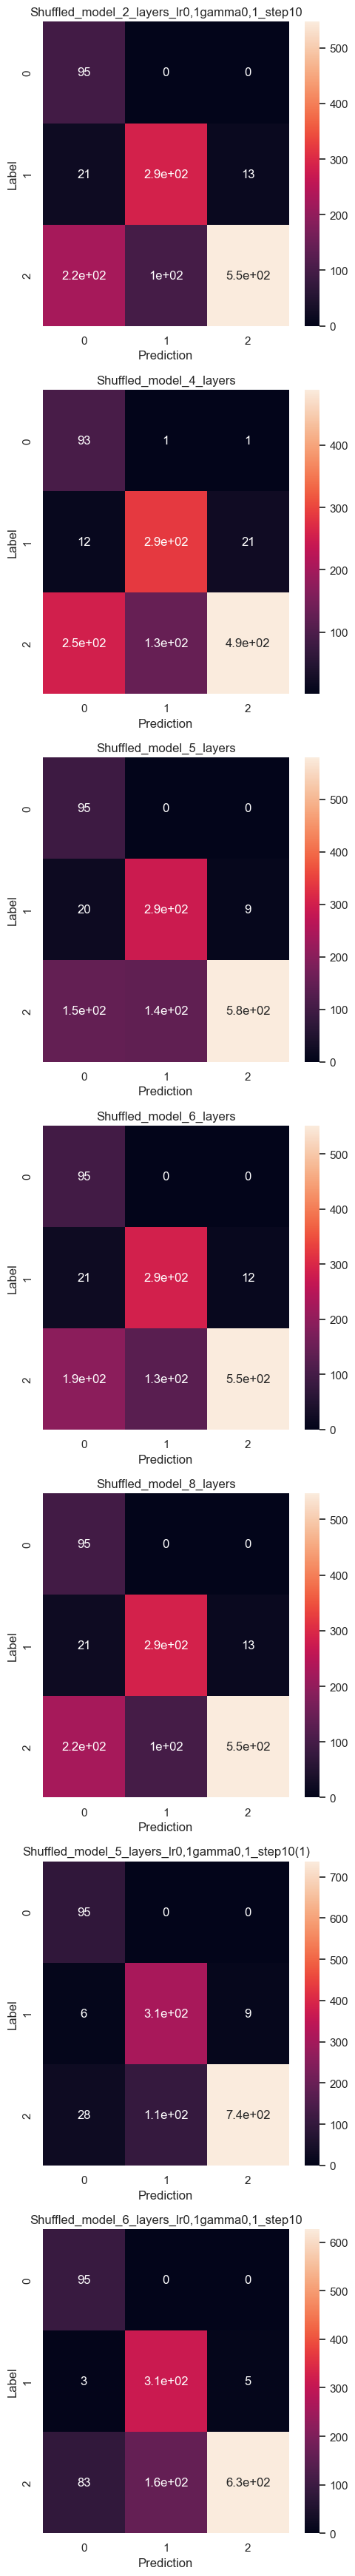

In [104]:
from pathlib import Path
model = ResNet(1,3,)
res = results(new_model, val_loader,'Shuffled_model_2_layers_lr0,1gamma0,1_step10',
              'Shuffled_model_4_layers','Shuffled_model_5_layers', 'Shuffled_model_6_layers','Shuffled_model_8_layers',
              'Shuffled_model_5_layers_lr0,1gamma0,1_step10(1)','Shuffled_model_6_layers_lr0,1gamma0,1_step10')

In [93]:
res

{'Shuffled_model_2_layers_lr0,1gamma0,1_step10': {'Accuracy': tensor(0.8405),
  'Precision': tensor(0.6657),
  'Recall': tensor(0.8405),
  'F1 Score': tensor(0.6702),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [ 21, 287,  13],
          [225, 100, 547]])},
 'Shuffled_model_4_layers': {'Accuracy': tensor(0.8123),
  'Precision': tensor(0.6347),
  'Recall': tensor(0.8123),
  'F1 Score': tensor(0.6320),
  'Confusion_Matrix': tensor([[ 93,   1,   1],
          [ 12, 288,  21],
          [253, 130, 489]])},
 'Shuffled_model_5_layers': {'Accuracy': tensor(0.8583),
  'Precision': tensor(0.6719),
  'Recall': tensor(0.8583),
  'F1 Score': tensor(0.6987),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [ 20, 292,   9],
          [148, 144, 580]])},
 'Shuffled_model_6_layers': {'Accuracy': tensor(0.8434),
  'Precision': tensor(0.6598),
  'Recall': tensor(0.8434),
  'F1 Score': tensor(0.6739),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [ 21, 288,  12],
         

### From the metrics all show that the best perfromaing model was the 5 layer model with learning rate of 0.1 with an lr scheduler.

In [108]:
df = pd.DataFrame(res)
df

,"Shuffled_model_2_layers_lr0,1gamma0,1_step10",Shuffled_model_4_layers,Shuffled_model_5_layers,Shuffled_model_6_layers,Shuffled_model_8_layers,"Shuffled_model_5_layers_lr0,1gamma0,1_step10(1)","Shuffled_model_6_layers_lr0,1gamma0,1_step10"
Accuracy,tensor(0.8405),tensor(0.8123),tensor(0.8583),tensor(0.8434),tensor(0.8405),tensor(0.9332),tensor(0.8980)
Precision,tensor(0.6657),tensor(0.6347),tensor(0.6719),tensor(0.6598),tensor(0.6657),tensor(0.8224),tensor(0.7253)
Recall,tensor(0.8405),tensor(0.8123),tensor(0.8583),tensor(0.8434),tensor(0.8405),tensor(0.9332),tensor(0.8980)
F1 Score,tensor(0.6702),tensor(0.6320),tensor(0.6987),tensor(0.6739),tensor(0.6702),tensor(0.8649),tensor(0.7695)
Confusion_Matrix,"[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(93), tensor(1), tensor(1)], [tensor(1...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(6...","[[tensor(95), tensor(0), tensor(0)], [tensor(3..."


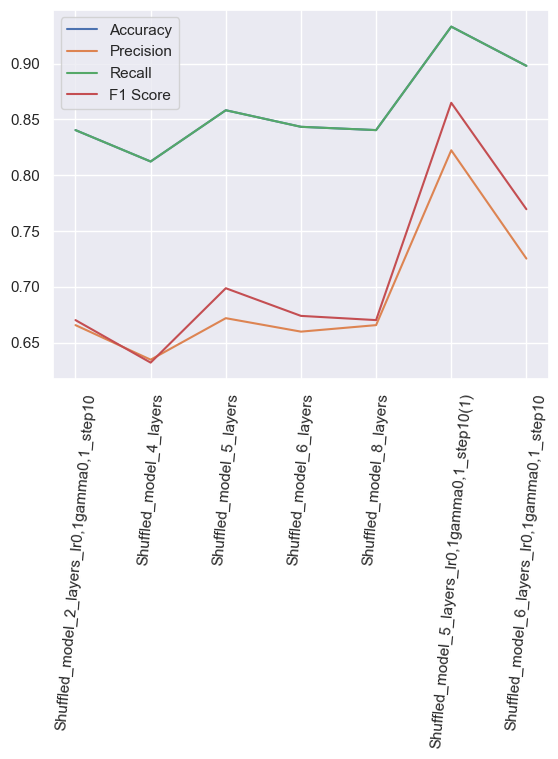

In [96]:
fig = plt.figure()
rows = df.index
row_index = 0
for i in range(2):
    for j in range(2):

        plt.plot(df.columns,df.loc[rows[row_index]])
        plt.xticks(rotation=85)
        row_index+=1
plt.legend(df.index)        
plt.show()
fig.tight_layout()
